In [ ]:
## Code V2 with synthetic data ##

In [31]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# FILE PATHS 
# -------------------------------------------------------------------
TRAIN_DATA_PATH = "synthetic_patients"
TEST_DATA_PATH  = "PhysioData/training/training_setA" 

# -------------------------------------------------------------------
# Load a single .psv file
# -------------------------------------------------------------------
def load_psv(file_path):
    return pd.read_csv(file_path, sep='|')

# -------------------------------------------------------------------
# Clean a patient dataframe
# -------------------------------------------------------------------
def clean_patient_df(df):
    df = df.dropna(how='all')       # remove empty rows
    df = df.replace(-1, np.nan)     # treat -1 as missing
    df = df.ffill().bfill()         # forward/back fill
    df = df.fillna(df.median())     # last fallback
    return df

# -------------------------------------------------------------------
# Convert 1 patient → 1-row feature vector
# -------------------------------------------------------------------
def extract_features(df):
    features = {}
    numeric_cols = [
        c for c in df.columns
        if c != "SepsisLabel" and np.issubdtype(df[c].dtype, np.number)
    ]

    for col in numeric_cols:
        features[col + "_mean"] = df[col].mean()
        features[col + "_std"]  = df[col].std()
        features[col + "_min"]  = df[col].min()
        features[col + "_max"]  = df[col].max()

    return features

# -------------------------------------------------------------------
# OPTION B: LOAD ONLY A FRACTION OF TEST FILES
# -------------------------------------------------------------------
def list_test_subset(test_folder, fraction=0.20, seed=42):
    random.seed(seed)
    all_files = [os.path.join(test_folder, f)
                 for f in os.listdir(test_folder)
                 if f.endswith(".psv")]

    subset_size = max(1, int(len(all_files) * fraction))
    return random.sample(all_files, subset_size)

# Same loader as load_patient_folder, but accepts a list of paths
def load_patient_list(file_paths):
    rows = []
    for full in file_paths:
        try:
            df = load_psv(full)
            df = clean_patient_df(df)
            feats = extract_features(df)
            feats["SepsisLabel"] = int(df["SepsisLabel"].max())
            rows.append(feats)
        except Exception as e:
            print("Error loading:", full, e)

    data = pd.DataFrame(rows)
    data = data.dropna(axis=1, how='all')
    return data

# -------------------------------------------------------------------
# Full folder loader (TRAIN ONLY)
# -------------------------------------------------------------------
def load_patient_folder(folder_path):
    rows = []
    for fname in os.listdir(folder_path):
        if fname.endswith(".psv"):
            full = os.path.join(folder_path, fname)
            try:
                df = load_psv(full)
                df = clean_patient_df(df)
                feats = extract_features(df)
                feats["SepsisLabel"] = int(df["SepsisLabel"].max())
                rows.append(feats)
            except Exception as e:
                print("Error loading file:", fname, e)

    data = pd.DataFrame(rows)
    data = data.dropna(axis=1, how='all')
    return data

# -------------------------------------------------------------------
# LOAD TRAIN + TEST DATA
# -------------------------------------------------------------------
print("Loading TRAIN DATA...")
train_data = load_patient_folder(TRAIN_DATA_PATH)
print("Train shape:", train_data.shape)

print("\nSampling TEST DATA (fast)…")
subset_paths = list_test_subset(TEST_DATA_PATH, fraction=0.20, seed=42)
test_data = load_patient_list(subset_paths)
print("Sampled test shape:", test_data.shape)

# -------------------------------------------------------------------
# ALIGN FEATURES (CRITICAL)
# -------------------------------------------------------------------
train_cols = set(train_data.columns)
test_cols  = set(test_data.columns)

missing_in_test = train_cols - test_cols - {"SepsisLabel"}
extra_in_test   = test_cols - train_cols - {"SepsisLabel"}

for col in missing_in_test:
    test_data[col] = train_data[col].median()

for col in extra_in_test:
    test_data = test_data.drop(columns=[col])

test_data = test_data[train_data.columns]




Loading TRAIN DATA...
Train shape: (2200, 157)

Sampling TEST DATA (fast)…
Sampled test shape: (4067, 157)


In [32]:
# -------------------------------------------------------------------
# MODEL TRAINING
# -------------------------------------------------------------------
X_train = train_data.drop("SepsisLabel", axis=1)
y_train = train_data["SepsisLabel"]

X_test  = test_data.drop("SepsisLabel", axis=1)
y_test  = test_data["SepsisLabel"]

rf = RandomForestClassifier(
    n_estimators=2000,
    max_depth=None,
    class_weight={0:1, 1:3},   # boosts minority class
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# -------------------------------------------------------------------
# MODEL INFERENCE
# -------------------------------------------------------------------
y_prob = rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

thresholds = np.linspace(0.05, 0.50, 10)

for t in thresholds:
    y_pred_t = (y_prob > t).astype(int)
    TP = ((y_test == 1) & (y_pred_t == 1)).sum()
    FN = ((y_test == 1) & (y_pred_t == 0)).sum()
    sensitivity = TP / (TP + FN)
    accuracy = (y_test == y_pred_t).mean()
    print(f"Threshold={t:.2f}  Sensitivity={sensitivity:.3f}  Accuracy={accuracy:.3f}")

Threshold=0.05  Sensitivity=1.000  Accuracy=0.080
Threshold=0.10  Sensitivity=0.969  Accuracy=0.141
Threshold=0.15  Sensitivity=0.787  Accuracy=0.416
Threshold=0.20  Sensitivity=0.500  Accuracy=0.666
Threshold=0.25  Sensitivity=0.272  Accuracy=0.789
Threshold=0.30  Sensitivity=0.167  Accuracy=0.843
Threshold=0.35  Sensitivity=0.083  Accuracy=0.871
Threshold=0.40  Sensitivity=0.043  Accuracy=0.893
Threshold=0.45  Sensitivity=0.015  Accuracy=0.907
Threshold=0.50  Sensitivity=0.009  Accuracy=0.916



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3743
           1       0.12      0.01      0.02       324

    accuracy                           0.92      4067
   macro avg       0.52      0.50      0.49      4067
weighted avg       0.86      0.92      0.88      4067

Accuracy: 0.9156626506024096
Sensitivity (Recall): 0.009259259259259259

Confusion Matrix:
[[3721   22]
 [ 321    3]]


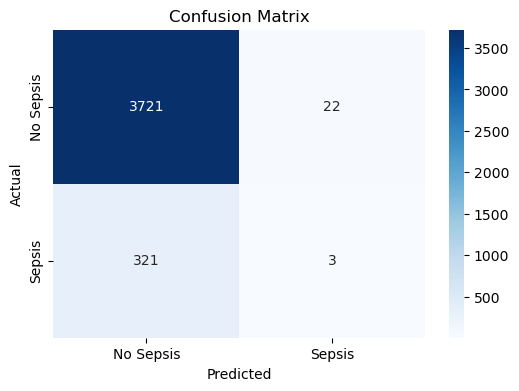

In [33]:
# -------------------------------------------------------------------
# EVALUATION
# -------------------------------------------------------------------
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
# Sensitivity Calc
TP = cm[1, 1]   # true positives
FN = cm[1, 0]   # false negatives

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
print("Sensitivity (Recall):", sensitivity)

print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Sepsis', 'Sepsis'],
            yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()